# Moving Average
Example of a simple technical analysis with a line chart on stock data using exponential moving averages to identify bullish and bearish trends.
[Data provided by IEX Cloud](https://iexcloud.io)

In [1]:
import numpy as np
import pandas as pd
import pyEX as pex
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#See Python documentation on configuration-file parser
#[ https://docs.python.org/3/library/configparser.html#supported-ini-file-structure ]
#
import configparser

iexcfg = configparser.ConfigParser()
iexcfg.read('.iexcloud')

tok = iexcfg['Tokens']['Ppk']
vers = iexcfg['Versioning']['vers']

#print("tok - [value: {}][type: {}]".format(tok, type(tok)))
#print("vers - [value: {}][type: {}]".format(vers, type(vers)))

In [3]:
ticker = 'NM' #NM TSLA ERC FM
timeframe = '1y'

In [4]:
stocklist = pex.refdata.iexSymbolsList(token=tok, version=vers)
ticker in stocklist

#To validate the above result, you may want to make a REST API call:
#curl -X GET https://cloud.iexapis.com/v1/ref-data/symbols?token=VALUE-OF-tok
#
#See IEX Cloud API documentation for details
#[ https://iexcloud.io/docs/api/#rest-how-to ]
#[ https://iexcloud.io/docs/api/#stocks ]
#


True

In [5]:
dframe = pex.stocks.chartDF(ticker, timeframe, None, tok, vers)
dframe.head()

,change,changeOverTime,changePercent,close,high,label,low,open,uClose,uHigh,uLow,uOpen,uVolume,volume
date,,,,,,,,,,,,,,
2018-09-28,0.00,0.000000,0.0000,7.08,7.39,"Sep 28, 18",7.00,7.07,0.7087,0.7395,0.7000,0.7079,688617,68862
2018-10-01,-0.13,-0.019331,-1.9331,6.95,7.25,"Oct 1, 18",6.90,7.01,0.6950,0.7250,0.6901,0.7010,568684,56868
2018-10-02,-0.63,-0.108791,-9.1223,6.31,7.00,"Oct 2, 18",6.28,7.00,0.6316,0.7000,0.6288,0.7000,1193987,119399
2018-10-03,0.18,-0.082828,2.9132,6.50,6.80,"Oct 3, 18",6.40,6.40,0.6500,0.6800,0.6400,0.6400,339905,33991
2018-10-04,-0.12,-0.100748,-1.9538,6.37,6.70,"Oct 4, 18",6.32,6.50,0.6373,0.6700,0.6320,0.6500,241067,24107


In [6]:
df = dframe[['close']]
df.reset_index(level=0, inplace=True)
df.columns

#plt.plot(df.date, df.close)
#plt.show()

Index(['date', 'close'], dtype='object')

In [7]:
shortspan = 10
longspan = 30
sma_short = df.close.rolling( window=shortspan ).mean()
sma_long = df.close.rolling( window=longspan ).mean()

#plt.plot(df.date, df.close, label=ticker )
#plt.plot(df.date, sma_short, label=ticker + ' ' + str(shortspan) + '-day SMA', color='orange' )
#plt.plot(df.date, sma_long, label=ticker + ' ' + str(longspan) + '-day SMA', color='magenta' )
#plt.legend( loc='lower right' )
#plt.show()

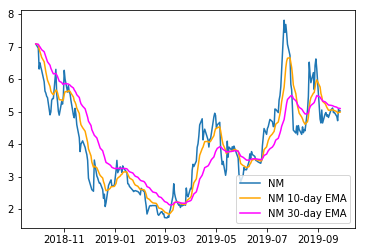

In [8]:
ema_short = df.close.ewm( span=shortspan, adjust=False ).mean()
ema_long = df.close.ewm( span=longspan, adjust=False ).mean()

#plt.style.use('bmh')
plt.plot(df.date, df.close, label=ticker)
plt.plot(df.date, ema_short, label=ticker + ' ' + str(shortspan) + '-day EMA', color='orange' )
plt.plot(df.date, ema_long, label=ticker + ' ' + str(longspan) + '-day EMA', color='magenta' )
plt.legend( loc='lower right' )
plt.show()

In [9]:
from bokeh.io import output_notebook
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.plotting import figure, show


In [10]:
signs = np.sign( ema_short - ema_long )
#any(signs==0)
bullish = [ index for index, value in enumerate(signs) if value>0 ]
bearish = [ index for index, value in enumerate(signs) if value<0 ]

def getZone( idx ):
    #Extraction of ranges taken from
    #[ https://stackoverflow.com/questions/2361945/detecting-consecutive-integers-in-a-list ]
    nums = idx
    ranges = sum( (list(t) for t in zip(nums, nums[1:]) if t[0]+1 != t[1]), [] )
    iranges = iter( nums[0:1] + ranges + nums[-1:] )
    
    idxleft = []
    idxright = []
    for n in iranges:
        idxleft.append(n)
        idxright.append(next(iranges))

    #print(idxleft)
    return {'top': np.ones_like(idxleft)*max(df.close),
            'right': [ df.date[x] for x in idxright ],
            'bottom': np.ones_like(idxleft)*min(df.close),
            'left': [ df.date[x] for x in idxleft ]}

bullish_zones = getZone( bullish )
bearish_zones = getZone( bearish )

In [11]:
output_notebook()

fig = figure( plot_width=800,
              plot_height=400,
              x_axis_type="datetime",
              active_drag="box_zoom" )

fig.line(df.date, df.close, line_width=2, muted_alpha=0.2, legend=ticker )
fig.line(df.date, ema_short, line_width=2, color="orange", muted_color="orange", muted_alpha=0.2, legend=ticker + ' ' + str(shortspan) + '-day EMA' )
fig.line(df.date, ema_long, line_width=2, color="magenta", muted_color="magenta", muted_alpha=0.2, legend=ticker + ' ' + str(longspan) + '-day EMA' )
#fig.varea(x=df.date, y1=ema_short, y2=ema_long, color="yellow", alpha=0.2)
fig.quad(top=bullish_zones['top'], right=bullish_zones['right'],
       bottom=bullish_zones['bottom'], left=bullish_zones['left'],
       color="green", alpha=0.15)
fig.quad(top=bearish_zones['top'], right=bearish_zones['right'],
       bottom=bearish_zones['bottom'], left=bearish_zones['left'],
       color="red", alpha=0.15)
fig.legend.location = "bottom_right"
fig.legend.click_policy = "mute"
show(fig)

Loading BokehJS ...